In [2]:
using Pkg
Pkg.activate(".")

  Activating project at `~/code/phasor_julia`


In [45]:
using Zygote, Lux, LuxCUDA, ComponentArrays, Plots, QuadGK, Interpolations, Optimisers, NNlib, JLD2
using Random: Xoshiro
using MLUtils: DataLoader

In [4]:
using PhasorNetworks

# Load the dataset

In [5]:
include("pixel_data.jl")

interpolate_roc (generic function with 1 method)

In [6]:
using Base: @kwdef

In [7]:
@kwdef mutable struct Args
    η::Float64 = 3e-4       ## learning rate
    batchsize::Int = 128    ## batch size
    epochs::Int = 10        ## number of epochs
    use_cuda::Bool = false   ## use gpu (if cuda available)
end

Args

In [8]:
args = Args(batchsize = 128)

Args(0.0003, 128, 10, false)

In [9]:
data_dir = "pixel_data/"

"pixel_data/"

In [10]:
file_pairs = get_dataset(data_dir)

10-element Vector{Tuple{String, String}}:
 ("pixel_data/labels/labels_d17301.parquet", "pixel_data/recon3D/recon3D_d17301.parquet")
 ("pixel_data/labels/labels_d17302.parquet", "pixel_data/recon3D/recon3D_d17302.parquet")
 ("pixel_data/labels/labels_d17303.parquet", "pixel_data/recon3D/recon3D_d17303.parquet")
 ("pixel_data/labels/labels_d17304.parquet", "pixel_data/recon3D/recon3D_d17304.parquet")
 ("pixel_data/labels/labels_d17305.parquet", "pixel_data/recon3D/recon3D_d17305.parquet")
 ("pixel_data/labels/labels_d17306.parquet", "pixel_data/recon3D/recon3D_d17306.parquet")
 ("pixel_data/labels/labels_d17307.parquet", "pixel_data/recon3D/recon3D_d17307.parquet")
 ("pixel_data/labels/labels_d17308.parquet", "pixel_data/recon3D/recon3D_d17308.parquet")
 ("pixel_data/labels/labels_d17309.parquet", "pixel_data/recon3D/recon3D_d17309.parquet")
 ("pixel_data/labels/labels_d17310.parquet", "pixel_data/recon3D/recon3D_d17310.parquet")

In [11]:
q, ylocal, pt = get_samples(file_pairs[1:2])

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 

In [12]:
q_test, ylocal_test, pt_test = get_samples(file_pairs[3:3]);

In [13]:
q |> size

(20, 13, 21, 99991)

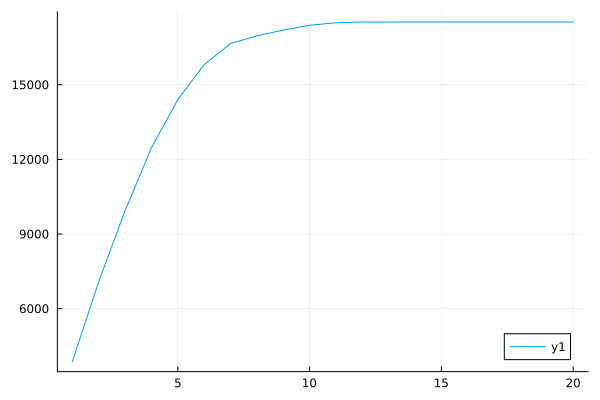

In [14]:
plot(sum(q[:,:,:,128], dims=(2,3)) |> vec)

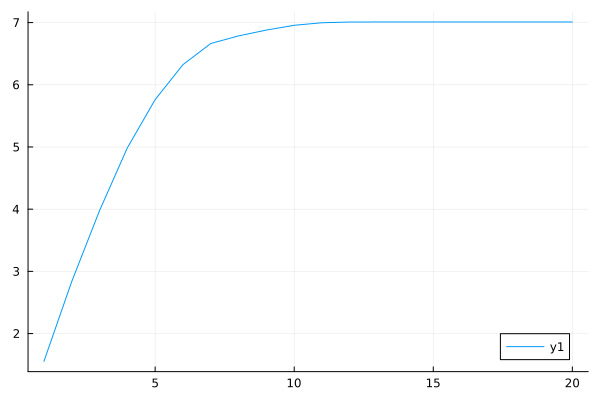

In [15]:
plot(sum(scale_charge(q[:,:,:,128]), dims=(2,3)) |> vec)

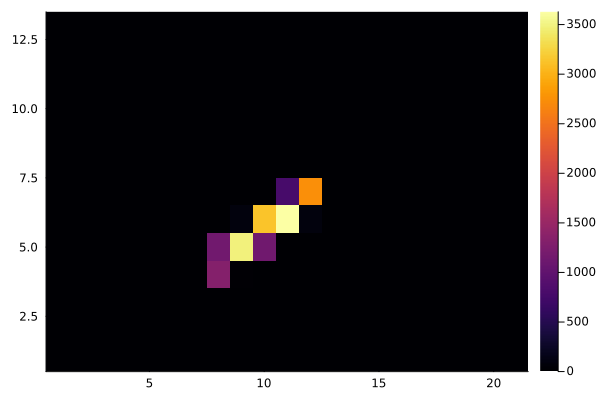

In [16]:
heatmap(q[12,:,:,128])

In [17]:
ylocal |> size

(99991,)

In [18]:
pt |> size

(99991,)

In [19]:
train_loader = DataLoader((q, ylocal, pt), batchsize=args.batchsize)

782-element DataLoader(::Tuple{Array{Float64, 4}, Vector{Float64}, Vector{Float64}}, batchsize=128)
  with first element:
  (20×13×21×128 Array{Float64, 4}, 128-element Vector{Float64}, 128-element Vector{Float64},)

In [20]:
test_loader = DataLoader((q_test, ylocal_test, pt_test), batchsize=args.batchsize)

391-element DataLoader(::Tuple{Array{Float64, 4}, Vector{Float64}, Vector{Float64}}, batchsize=128)
  with first element:
  (20×13×21×128 Array{Float64, 4}, 128-element Vector{Float64}, 128-element Vector{Float64},)

In [21]:
x, xl, y = first(train_loader)

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 

In [22]:
x |> size

(20, 13, 21, 128)

In [23]:
n_px = size(x, 2) 
n_in = n_px + 1

14

# Set up the model

In [24]:
function process_inputs(x, y_local)
    x = scale_charge(x)
    x = sum(x, dims=(1,3))
    n_batch = size(x, 4)
    x = reshape(x, (n_px, n_batch))
    y_local = reshape(y_local, (1, n_batch))

    x = cat(x, y_local, dims = 1)
    return x
end

process_inputs (generic function with 1 method)

In [25]:
process_inputs(x, xl)

14×128 Matrix{Float64}:
  0.0       0.0       0.0       0.0      …   0.0       0.0        0.0
  0.0       0.00728   0.0       0.0          0.0       0.0002     0.0
  0.01548   3.89436   0.04744   0.02484      0.0       0.89496    0.02688
  4.53608  22.421     5.53156  10.3167       0.0      45.6419     8.18032
 13.0276   28.691    14.8939   42.2308       0.08     88.6978    38.3292
 18.1824   29.1889   21.668    39.5168   …  17.8984   40.6906    50.7078
 17.2391   11.8402   24.0816   74.3496      49.9682   -1.49488   27.1796
 12.8535   -0.58136   8.4348   -3.04328      0.58264   0.0       -1.61592
  7.73868   0.0      -0.44068  -0.00316     -0.19872   0.0        0.0
 -0.07108   0.0       0.0       0.0         -0.0002    0.0        0.0
  0.0       0.0       0.0       0.0      …   0.0       0.0        0.0
  0.0       0.0       0.0       0.0          0.0       0.0        0.0
  0.0       0.0       0.0       0.0          0.0       0.0        0.0
 -6.94104  -4.33669  -7.79379  -2.67448      

In [26]:
model = Chain(
    BatchNorm(n_in),
    x -> tanh.(x),
    PhasorDense(n_in => 128),
    PhasorDense(128 => 3) 
)

Chain(
    layer_1 = BatchNorm(14, affine=true, track_stats=true),  # 28 parameters, plus 29
    layer_2 = WrappedFunction{:direct_call}(var"#39#40"()),
    layer_3 = PhasorDense((14, 128)),   # 1_920 parameters
    layer_4 = PhasorDense((128, 3)),    # 387 parameters
)         # Total: 2_335 parameters,
          #        plus 29 states.

In [27]:
rng = Xoshiro(42)
ps, st = Lux.setup(rng, model)

((layer_1 = (scale = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), layer_2 = NamedTuple(), layer_3 = (weight = Float32[-0.011489658 0.12606403 … 0.0047437637 -0.13452569; -0.09446841 0.07400124 … 0.07980053 -0.13867775; … ; 0.10672839 -0.16736038 … -0.10951539 -0.05882632; 0.052183025 -0.08769705 … 0.07845488 -0.18887484], bias = ComplexF32[1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im  …  1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im]), layer_4 = (weight = Float32[0.5993126 0.4167722 … -0.218614 0.34311864; -0.12842335 -0.9040824 … 0.2625846 0.21363495; 0.3049119 -0.8346293 … -0.7711599 1.7686664], bias = ComplexF32[1.0f0 + 0

In [28]:
y_naive, _ = model(process_inputs(x, xl), ps, st)

([-0.9659164255069418 -0.8596251777576682 … -0.891577570093885 -0.9188927667080372; 0.9079151667164291 -0.9851303472186858 … 0.9765458025898525 0.9658370718694028; 0.005082167855675906 -0.009880385050765033 … -0.017045744092611986 0.04095992226791468], (layer_1 = (running_mean = [2.7343750407453623e-5, 0.011720312674646264, 0.158769846115855, 1.0494967656387197, 3.214049110393063, 4.16443265580488, 3.6319093041196675, 1.1148337041123164, 0.11779922050534516, -0.004528312567477114, -0.00042331250630784777, 0.0, 0.0, 0.07180550185123537], running_var = [0.9000008921638939, 1.0404967775678888, 4.9352839507701995, 44.36456898678814, 214.18895577466316, 280.3147835280541, 244.4854051874365, 56.37100367649326, 5.12052608225659, 0.9041690609789671, 0.90022934380656, 0.8999999761581421, 0.8999999761581421, 2.9173396135808085], training = Val{true}()), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple()))

In [29]:
y_naive |> size

(3, 128)

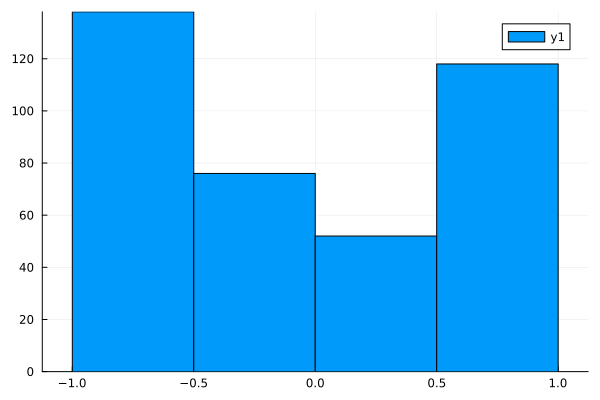

In [30]:
histogram(y_naive |> vec)

In [31]:
using Statistics: std, median, mean

In [32]:
using OneHotArrays

In [33]:
function get_truth(pt, threshold::Real = 0.2)
    return 1 .* (pt .> threshold) .+ 2 .* (pt .< -threshold)
end

get_truth (generic function with 2 methods)

In [34]:
function momentum_to_label(pt, threshold::Real = 0.2)
    y = onehotbatch(get_truth(pt, threshold), (0, 1, 2))
    return y
end

momentum_to_label (generic function with 2 methods)

In [35]:
labels = momentum_to_label(pt)

3×99991 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  …  ⋅  1  ⋅  1  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1
 1  1  ⋅  1  1  ⋅  1  1  ⋅  ⋅  1  1  ⋅     1  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  1  ⋅
 ⋅  ⋅  1  ⋅  ⋅  1  ⋅  ⋅  1  1  ⋅  ⋅  1     ⋅  ⋅  ⋅  ⋅  ⋅  1  1  1  1  ⋅  ⋅  ⋅

In [36]:
function loss(x, xl, y, model, ps, st, threshold)
    y_pred, st = model(process_inputs(x, xl), ps, st)
    y = momentum_to_label(y, threshold)
    loss = quadrature_loss(y_pred, y) |> mean
    return loss, st
end

loss (generic function with 1 method)

In [37]:
l0, st0 = @time loss(x, xl, y, model, ps, st, 0.2)

  0.163034 seconds (582.65 k allocations: 46.733 MiB, 6.41% gc time, 99.16% compilation time)


(1.361679508148608, (layer_1 = (running_mean = [2.7343750407453623e-5, 0.011720312674646264, 0.158769846115855, 1.0494967656387197, 3.214049110393063, 4.16443265580488, 3.6319093041196675, 1.1148337041123164, 0.11779922050534516, -0.004528312567477114, -0.00042331250630784777, 0.0, 0.0, 0.07180550185123537], running_var = [0.9000008921638939, 1.0404967775678888, 4.9352839507701995, 44.36456898678814, 214.18895577466316, 280.3147835280541, 244.4854051874365, 56.37100367649326, 5.12052608225659, 0.9041690609789671, 0.90022934380656, 0.8999999761581421, 0.8999999761581421, 2.9173396135808085], training = Val{true}()), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple()))

In [38]:
l0

1.361679508148608

In [39]:
function train(model, ps, st, train_loader, threshold::Real = 0.2; kws...)
    args = Args(; kws...) ## Collect options in a struct for convenience

    device = cpu

    @info "Constructing model and starting training"
    ## Construct model
    #model = build_model() |> device

    ## Optimizer
    opt_state = Optimisers.setup(Adam(3e-4), ps)
    losses = []

    ## Training
    for epoch in 1:args.epochs
        epoch_losses = []
        for (x, xl, y) in train_loader
            (loss_val, st), gs = withgradient(p -> loss(x, xl, y, model, p, st, threshold), ps)
            append!(epoch_losses, loss_val)
            opt_state, ps = Optimisers.update(opt_state, ps, gs[1]) ## update parameters
        end
        append!(losses, mean(epoch_losses))
    end

    return losses, ps, st
end

train (generic function with 2 methods)

In [40]:
@time loss_history, pst, stt = train(model, ps, st, train_loader, 0.2, epochs = 5)

[ Info: Constructing model and starting training


 45.655235 seconds (41.56 M allocations: 144.297 GiB, 19.42% gc time, 29.58% compilation time)


(Any[0.361762073859551, 0.20601299946153698, 0.19947192490809476, 0.19144424919801323, 0.18522684992982696], (layer_1 = (scale = Float32[0.94766945, 1.0200474, 1.0080928, 0.9071987, 1.1200871, 0.85243744, 1.1039066, 1.0880357, 1.0622436, 0.7271087, 0.699433, 0.88765657, 0.8011488, 0.28768685], bias = Float32[-0.07944097, -0.040372886, 0.057647318, 0.295794, 0.011687726, 0.17731874, -0.09633987, 0.16822088, -0.088599645, -0.016848983, 0.009394613, 0.09477714, -0.064789206, 0.12654647]), layer_2 = NamedTuple(), layer_3 = (weight = Float32[-0.036571644 0.10342837 … -0.013026166 -0.116893; -0.1231677 0.045066502 … 0.08829288 -0.09052951; … ; 0.110651135 -0.18201007 … -0.05108299 -0.022416167; 0.062476017 -0.06807702 … 0.044632692 -0.1162501], bias = ComplexF32[1.0073818f0 + 0.01707949f0im, 1.0129353f0 + 0.009437937f0im, 0.9993685f0 - 0.01733718f0im, 1.0119526f0 - 0.045299668f0im, 0.99740136f0 + 0.06295349f0im, 0.97817403f0 - 0.024789965f0im, 0.9831844f0 + 0.005375393f0im, 0.9979576f0 + 0.0

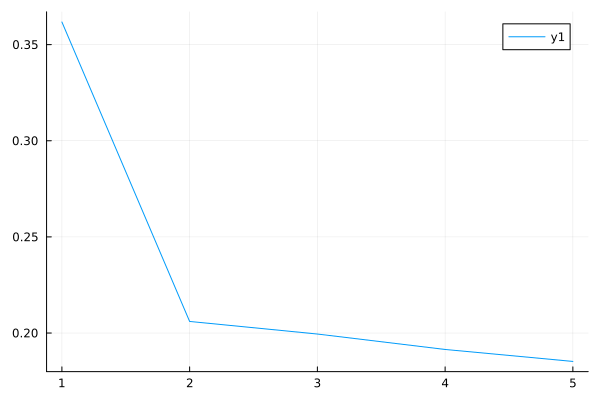

In [41]:
plot(loss_history)

In [42]:
loss(x, xl, y, model, pst, stt, 0.2)[1]

0.1886641175816092

# Load a Trained version

In [46]:
trained = load("trained_nns/pmlp_id_43_epoch_100.jld2")

Dict{String, Any} with 2 entries:
  "params" => (layer_1 = (scale = Float32[0.461171, 0.794577, 1.04559, 0.946624…
  "state"  => (layer_1 = (running_mean = [0.575794, 0.684621, 3.87745, 16.4577,…

In [47]:
pst = trained["params"]

(layer_1 = (scale = Float32[0.4611713, 0.7945772, 1.0455916, 0.9466239, 0.9983645, 0.7986385, 1.0625937, 1.076156, 1.085038, 0.17968072, 0.21605618, 0.16161042, 0.089231364, 0.3393442], bias = Float32[-0.30808827, 0.103240624, 0.27551818, 0.5620901, 0.28622818, 0.5678, 0.15927714, 0.38617665, -0.0020063354, 0.12638877, -0.105870426, -0.116136976, 0.027554784, 0.33653456]), layer_2 = NamedTuple(), layer_3 = (weight = Float32[-0.05868069 -0.034977213 … 0.44358674 0.27405196; 0.10406588 0.0152126 … 0.019462781 -0.17392358; … ; -0.05868901 0.17384061 … 0.021038758 -0.031678833; -0.20989293 0.22455822 … -0.078325585 0.09693501], bias = ComplexF32[0.97786313f0 + 0.024052907f0im, 1.000072f0 + 0.0338428f0im, 0.89760166f0 + 0.086402066f0im, 0.98783225f0 - 0.013903405f0im, 1.0128567f0 + 0.009071913f0im, 0.96993476f0 - 0.11209156f0im, 0.9854144f0 + 0.08480665f0im, 1.0044348f0 + 0.0305721f0im, 1.0157015f0 + 0.0050732377f0im, 0.9813482f0 + 0.04406561f0im  …  0.98481995f0 + 0.004036587f0im, 0.987186

In [48]:
sttf = Lux.testmode(trained["state"])

(layer_1 = (running_mean = [0.5757944121368425, 0.6846214445057881, 3.877447210797926, 16.457718797941705, 40.50550733079511, 46.45902297891875, 34.455593553787885, 11.694720261830742, 1.4321486865495832, 0.27754491012521154, 0.20938791166720094, 0.09354000307185677, 0.11033681559878909, 0.15291454619067543], running_var = [45.4440043349743, 30.597847176643445, 142.5825230347542, 785.3730588946706, 2787.8957479624682, 2453.057413839121, 2345.648527495587, 722.0711161220706, 91.57263090145504, 19.209888472669824, 10.95922934152389, 2.537559208572711, 11.005162970582472, 19.956601029145197], training = Val{false}()), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple())

In [49]:
loss(x, xl, y, model, pst, sttf, 0.2)

(0.14740021332336792, (layer_1 = (running_mean = [0.5757944121368425, 0.6846214445057881, 3.877447210797926, 16.457718797941705, 40.50550733079511, 46.45902297891875, 34.455593553787885, 11.694720261830742, 1.4321486865495832, 0.27754491012521154, 0.20938791166720094, 0.09354000307185677, 0.11033681559878909, 0.15291454619067543], running_var = [45.4440043349743, 30.597847176643445, 142.5825230347542, 785.3730588946706, 2787.8957479624682, 2453.057413839121, 2345.648527495587, 722.0711161220706, 91.57263090145504, 19.209888472669824, 10.95922934152389, 2.537559208572711, 11.005162970582472, 19.956601029145197], training = Val{false}()), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple()))

In [50]:
yt, _ = model(process_inputs(x, xl), pst, stt)

([0.01868217917718654 0.015304813091591454 … 0.007393048272191069 0.01505893168771689; 0.49223465986282006 0.16924536824316216 … 0.14042329051507482 0.2537801355672714; 0.026454057870702527 0.2502206267390465 … 0.3858581689917607 0.1852071057171851], (layer_1 = (running_mean = [0.5182423009455571, 0.6278795964072084, 3.648472243388443, 15.861443291403662, 39.669004742382114, 45.977552229162335, 34.641942681043396, 11.640081660936126, 1.4067330042548845, 0.24526209992802694, 0.18802580300197616, 0.08418600053450363, 0.0993031314082755, 0.2094285897770764], running_var = [40.899603734013134, 27.67855853087932, 132.3595513064586, 750.3003032910807, 2722.395062496112, 2487.166397521659, 2354.6690240326875, 705.3349909946818, 86.63589173414633, 17.293068252224234, 9.86353551373153, 2.283803227215314, 9.904646411140693, 19.978280087850898], training = Val{true}()), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple()))

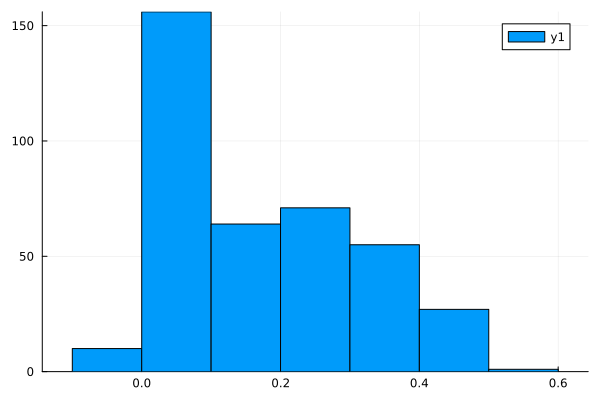

In [51]:
histogram(yt |> vec)

# Calculate the Test Loss

In [52]:
xts, xlts, yts = first(test_loader)

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 

In [53]:
function accuracy(x, xl, y, model, ps, st, threshold::Real)
    y_truth = get_truth(y, threshold)
    y_pred, _ = model(process_inputs(x, xl), ps, st)
    #predict & correct for zero indexing
    y_labels = predict_quadrature(y_pred) .- 1
    right = sum(y_truth .== y_labels)
    return right
end

accuracy (generic function with 1 method)

In [54]:
yth, _ = model(process_inputs(q_test[:,:,:,1:10000], ylocal_test[1:10000]), pst, sttf)

([7.413117522454515e-5 0.02057979133795129 … 0.016282476040524754 0.0231592410285276; -0.0897537544700889 0.08616329597502996 … 0.021667115317241855 0.18728028341298947; 0.4562194677287865 0.5037146006057786 … 0.3688283001536831 0.2559522024991017], (layer_1 = (running_mean = [0.5757944121368425, 0.6846214445057881, 3.877447210797926, 16.457718797941705, 40.50550733079511, 46.45902297891875, 34.455593553787885, 11.694720261830742, 1.4321486865495832, 0.27754491012521154, 0.20938791166720094, 0.09354000307185677, 0.11033681559878909, 0.15291454619067543], running_var = [45.4440043349743, 30.597847176643445, 142.5825230347542, 785.3730588946706, 2787.8957479624682, 2453.057413839121, 2345.648527495587, 722.0711161220706, 91.57263090145504, 19.209888472669824, 10.95922934152389, 2.537559208572711, 11.005162970582472, 19.956601029145197], training = Val{false}()), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple()))

In [55]:
accuracy(q_test[:,:,:,1:10000], ylocal_test[1:10000], pt_test[1:10000], model, pst, sttf, 0.2)

7149

In [56]:
using LinearAlgebra: diag

In [57]:
roc = tpr_fpr(yth, pt_test[1:10000])

([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

In [87]:
roc_fn = linear_interpolation(average_duplicate_knots(roc[2], roc[1])...)

20-element extrapolate(interpolate((::Vector{Float64},), ::Vector{Float64}, Gridded(Linear())), Throw()) with element type Float64:
 0.0
 0.0
 0.0003
 0.0022
 0.0158
 0.0812
 0.2223
 0.396
 0.5546
 0.7041
 0.8089
 0.876
 0.9146
 0.9335
 0.9963
 0.999
 0.9996
 1.0
 1.0
 1.0

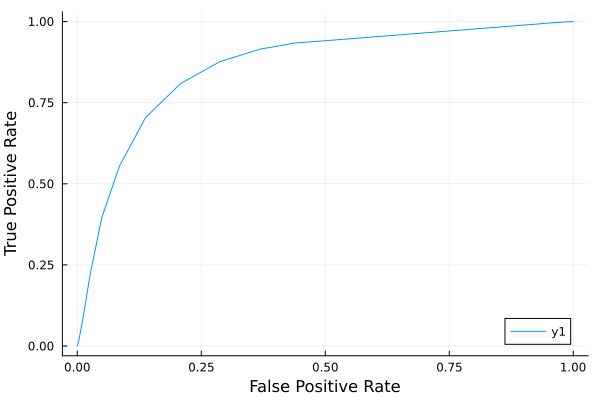

In [88]:
plot(roc[2], roc[1])
xlabel!("False Positive Rate")
ylabel!("True Positive Rate")

In [89]:
auc, _ = quadgk(roc_fn, 0.0, 1.0)

(0.8605830155809093, 1.232299361568993e-8)

# Build a Spiking Version

In [93]:
sa = SpikingArgs()
repeats = 8

8

In [94]:
model_spk = Chain(
    BatchNorm(n_in),
    x -> tanh.(x),
    MakeSpiking(sa, repeats),
    PhasorDense(n_in => 128),
    PhasorDense(128 => 3) 
)

Chain(
    layer_1 = BatchNorm(14, affine=true, track_stats=true),  # 28 parameters, plus 29
    layer_2 = WrappedFunction{:direct_call}(var"#50#51"()),
    layer_3 = MakeSpiking(Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, 8, (0.0, 8.0), 0.0),
    layer_4 = PhasorDense((14, 128)),   # 1_920 parameters
    layer_5 = PhasorDense((128, 3)),    # 387 parameters
)         # Total: 2_335 parameters,
          #        plus 29 states.

In [95]:
function convert_pmlp_params(pmlp_ps)
    # Add a dummy layer of params for the make_spiking layer
    spk_ps = (layer_1 = pmlp_ps.layer_1, 
            layer_2 = pmlp_ps.layer_2,
            layer_3 = NamedTuple(),
            layer_4 = pmlp_ps.layer_3,
            layer_5 = pmlp_ps.layer_4)
    return spk_ps
end      

convert_pmlp_params (generic function with 1 method)

In [96]:
pst_spk = convert_pmlp_params(pst)
sttf_spk = convert_pmlp_params(sttf)

(layer_1 = (running_mean = [0.5757944121368425, 0.6846214445057881, 3.877447210797926, 16.457718797941705, 40.50550733079511, 46.45902297891875, 34.455593553787885, 11.694720261830742, 1.4321486865495832, 0.27754491012521154, 0.20938791166720094, 0.09354000307185677, 0.11033681559878909, 0.15291454619067543], running_var = [45.4440043349743, 30.597847176643445, 142.5825230347542, 785.3730588946706, 2787.8957479624682, 2453.057413839121, 2345.648527495587, 722.0711161220706, 91.57263090145504, 19.209888472669824, 10.95922934152389, 2.537559208572711, 11.005162970582472, 19.956601029145197], training = Val{false}()), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple())

In [106]:
yth_spk, _ = model_spk(process_inputs(q_test[:,:,:,1:10000], ylocal_test[1:10000]), pst_spk, sttf_spk)

(SpikingCall(Spike Train: (3, 10000) with 240000 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0, 8.0)), (layer_1 = (running_mean = [0.5757944121368425, 0.6846214445057881, 3.877447210797926, 16.457718797941705, 40.50550733079511, 46.45902297891875, 34.455593553787885, 11.694720261830742, 1.4321486865495832, 0.27754491012521154, 0.20938791166720094, 0.09354000307185677, 0.11033681559878909, 0.15291454619067543], running_var = [45.4440043349743, 30.597847176643445, 142.5825230347542, 785.3730588946706, 2787.8957479624682, 2453.057413839121, 2345.648527495587, 722.0711161220706, 91.57263090145504, 19.209888472669824, 10.95922934152389, 2.537559208572711, 11.005162970582472, 19.956601029145197], training = Val{false}()), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple()))

In [107]:
yth_spk2 = train_to_phase(yth_spk);

In [108]:
size(yth_spk2)

(8, 3, 10000)

In [109]:
size(yth)

(3, 10000)

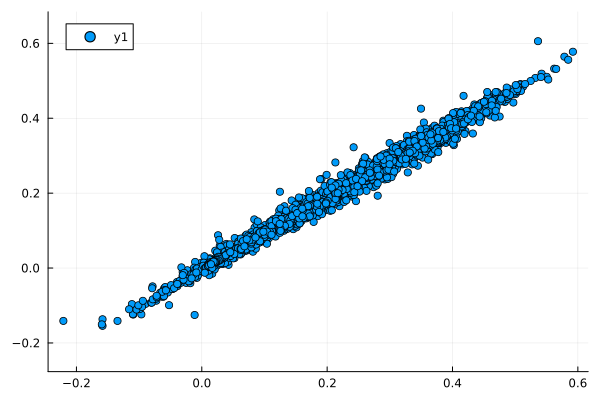

In [110]:
scatter(vec(yth[:,1:1000]), vec(yth_spk2[end-1,:,:]))

In [112]:
roc_spk = tpr_fpr(yth_spk2[end-1,:,:], pt_test[1:10000])

([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

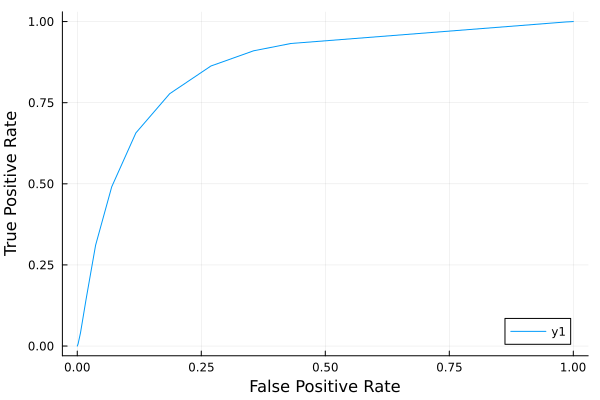

In [113]:
plot(roc_spk[2], roc_spk[1])
xlabel!("False Positive Rate")
ylabel!("True Positive Rate")

In [114]:
roc_spk_fn = linear_interpolation(average_duplicate_knots(roc_spk[2], roc_spk[1])...)

20-element extrapolate(interpolate((::Vector{Float64},), ::Vector{Float64}, Gridded(Linear())), Throw()) with element type Float64:
 0.0
 0.0
 0.0003
 0.0012
 0.0062
 0.0406
 0.1431
 0.3107
 0.4907
 0.6569
 0.7777
 0.863
 0.9099
 0.9324
 0.9947
 0.9988
 0.9996
 1.0
 1.0
 1.0

In [115]:
quadgk(roc_spk_fn, 0.0, 1.0)

(0.8593352360792346, 1.2778412592237121e-8)